### Class K_Nearest_PMedian

+----------------------------------+
|          K_Nearest_PMedian       |
+----------------------------------+
| - name: str                      |
| - problem: pulp.LpProblem        |
| - aij: sparse matrix             |
+----------------------------------+
| + __init__(name, problem, aij)   |
| + __add_obj(max_distance, range_clients, range_facility) |
| + create_sparse_matrix(clients, facilities, k_list, metric) |
| + create_k_list(k_list)          |
| + solve(solver, results)         |
| + from_sparse_matrix(sparse_distance_matrix, weights, facility_capacities, name) |
| + from_geodataframe(k_list, gdf_demand, gdf_fac, demand_col, facility_col, weights_cols, facility_capacity_col, distance_metric, name) |
+----------------------------------+
              ^
              |
+-------------|------------+
|                           |
|       LocateSolver        |
|   (BaseSpOptExactSolver)  |
|                           |
+---------------------------+
|                           |
| - facility_client_array() |
| - client_facility_array() |
| - get_mean_distance()     |
+---------------------------+
              ^
              |
+-------------|------------+
|                           |
|   BaseOutputMixin (Mixin) |
|                           |
+---------------------------+
|                           |
| - output_results()        |
| - save_results()          |
+---------------------------+
              ^
              |
+-------------|------------+
|                           |
|   MeanDistanceMixin (Mixin)|
|                           |
+---------------------------+
|                           |
| - calculate_mean_distance()|
+---------------------------+
              ^
              |
+-------------|------------+
|                           |
|   FacilityModelBuilder    |
|                           |
+---------------------------+
|                           |
| - add_facility_integer_variable()|
+---------------------------+


In [4]:
import warnings
from typing import Union

import numpy as np
import pulp
from geopandas import GeoDataFrame
from scipy.spatial.distance import cdist

from spopt.locate import p_median
from spopt.locate.base import (
    BaseOutputMixin,
    FacilityModelBuilder,
    LocateSolver,
    MeanDistanceMixin,
    SpecificationError,
)

In [6]:
from scipy.sparse import find
from pointpats.geometry import build_best_tree
from scipy.sparse import csr_matrix

In [22]:
class K_Nearest_PMedian(LocateSolver, BaseOutputMixin, MeanDistanceMixin):
    r"""
    Implement the k nearest p-median optimization model and solve it.

    Parameters
    ----------

    name : str
        The problem name.
    problem : pulp.LpProblem
        A ``pulp`` instance of an optimization model that contains
        constraints, variables, and an objective function.
    aij : sparse matrix
        A sparse cost matrix in the form of a 2D array between origins and destinations.
    """

    def __init__(
        self,
        name: str,
        problem: pulp.LpProblem,
        aij: np.array,
    ):
        self.aij = aij
        self.name = name
        self.problem = problem
    
    def __add_obj(self, max_distance: np.array, range_clients: range, range_facility: range) -> None:
        """
        Add the objective function to the model.

        objective = pulp.lpSum(
            pulp.lpSum(
                decision.get((i, j), 0) * sparse_distance_matrix[i, j] for j in r_fac
                )
                + (decision_g[i] * (max_distance[i] + 1))
                for i in r_cli
                )
        """
        cli_assgn_vars = getattr(self, "cli_assgn_vars")
        placeholder_vars = getattr(self, "placeholder_vars")

        self.problem += (
            pulp.lpSum(
                pulp.lpSum
                (
                    self.aij[i, j] * cli_assgn_vars.get((i, j), 0)
                    for j in range_facility
                ) + (placeholder_vars[i] * (max_distance[i] + 1))
                for i in range_clients
            ),
            "objective function",
        )
    
    @classmethod
    def create_sparse_matrix(
        cls,
        clients: np.array, 
        facilities: np.array, 
        k_list: np.array, 
        metric):
        """
        create a sparse matrix reprensents the distance between clients and their k nearest facilities
        """
        row_shape = len(clients)
        column_shape = len(facilities)

        # check the k value with the total number of facilities
        for k in k_list:
            if k > column_shape:
                raise ValueError(
                    f"The value of k should be no more than the number of total facilities ({column_shape})."
                    )

        # Initialize empty lists to store the data for the sparse matrix
        data = []
        row_index = []
        col_index = []

        # create the suitable Tree
        tree = build_best_tree(facilities, metric)

        for i, k in enumerate(k_list):
            # Query the Tree to find the k nearest facilities for each client
            distances, k_nearest_facilities_indices = tree.query([clients[i]], k=k)

            # extract the contents of the inner array
            distances = distances[0].tolist()
            k_nearest_facilities_indices = k_nearest_facilities_indices[0].tolist()
        
            # Append the data for the sparse matrix
            data.extend(distances)
            row_index.extend([i] * k)
            col_index.extend(k_nearest_facilities_indices)
        # Create the sparse matrix using csr_matrix
        sparse_matrix = csr_matrix((data, (row_index, col_index)), shape=(row_shape, column_shape))
        return sparse_matrix

    def create_k_list(
        self,
        k_list: np.array):
        """
        increase the k value of client with the g_i > 0, create a new k list
        """
        new_k_list = k_list.copy()
        placeholder_vars = getattr(self, "placeholder_vars")
        for i in range(len(placeholder_vars)):
            if placeholder_vars[i].value() > 0:
                new_k_list[i] = new_k_list[i] + 1
        return new_k_list

    def solve(self, solver: pulp.LpSolver, results: bool = True):
        """
        Solve the ``PMedian`` model.
        """
        self.problem.solve(solver)
        self.check_status()

        """
        if results:
            self.facility_client_array()
            self.client_facility_array()
            self.get_mean_distance()
        """
        return self

    @classmethod
    def from_sparse_matrix(
        cls,
        sparse_distance_matrix, 
        weights: np.array,
        facility_capacities: np.array = None,
        name: str = "k-nearest-p-median"):
        """
        create a K_Nearest_PMedian object from the calculated sparse matrix 
        """

        n_cli = sparse_distance_matrix.shape[0]
        r_cli = range(n_cli)
        r_fac = range(sparse_distance_matrix.shape[1])

        weights_sum = weights.sum()
        weights = np.reshape(weights, (n_cli, 1))
        aij = sparse_distance_matrix.multiply(weights).tocsr()

        # create the object
        model = pulp.LpProblem(name, pulp.LpMinimize)
        k_nearest_p_median = K_Nearest_PMedian(name, model, aij)

        # add all the 1)decision variable, 2)objective function, and 3)constraints

        # Facility integer decision variable
        FacilityModelBuilder.add_facility_integer_variable(k_nearest_p_median, r_fac, "y[{i}]")
        fac_vars = getattr(k_nearest_p_median, "fac_vars")
        # Placeholder decision variable
        placeholder_vars = pulp.LpVariable.dicts("g", (i for i in r_cli), 0, 1, pulp.LpBinary)
        setattr(k_nearest_p_median, "placeholder_vars", placeholder_vars)
        # Client assignment integer decision variables
        row_indices, col_indices, values = find(aij)
        cli_assgn_vars = pulp.LpVariable.dicts(
            "z", [(i, j) for i, j in zip(row_indices, col_indices)], 0, 1, pulp.LpBinary)
        setattr(k_nearest_p_median, "cli_assgn_vars", cli_assgn_vars)

        # objective function
        max_distance = aij.max(axis=1).toarray().flatten()
        k_nearest_p_median.__add_obj(max_distance, r_cli, r_fac)

        # Create assignment constraints. (need to create a new method in FacilityModelBuilder)
        for i in r_cli:
            model += (
                pulp.lpSum(cli_assgn_vars.get((i, j), 0) for j in r_fac)
                + placeholder_vars[i] == 1
            )
        # Create the facility capacity constraints: 
        # (modify then can use FacilityModelBuilder.add_facility_capacity_constraint)
        for j in col_indices:
            model += (
                pulp.lpSum(weights[i] * cli_assgn_vars.get((i, j), 0) for i in r_cli) 
                <= fac_vars[j] * facility_capacities[j]
            )
        # create the total capacity constraints
        model += pulp.lpSum(fac_vars[j] * facility_capacities[j] for j in r_fac) >= weights_sum
        
        return k_nearest_p_median

    @classmethod
    def from_geodataframe(
        cls,
        k_list: np.array,
        gdf_demand: GeoDataFrame,
        gdf_fac: GeoDataFrame,
        demand_col: str,
        facility_col: str,
        weights_cols: str,
        facility_capacity_col: str = None,
        distance_metric: str = "euclidean",
        name: str = "k-nearest-p-median",
    ):
        """
        The iteration which can find the optimal solution of the given geodataframe of clients 
        and facilities and k value.
        """

        # intialize the sum of g_i
        sum_gi = 1

        # create the array of coordinate of clients and facilities
        dem = gdf_demand[demand_col]
        fac = gdf_fac[facility_col]
        dem_data = np.array([dem.x.to_numpy(), dem.y.to_numpy()]).T
        fac_data = np.array([fac.x.to_numpy(), fac.y.to_numpy()]).T

        if gdf_demand.crs != gdf_fac.crs:
            raise ValueError(
                "Geodataframes crs are different: "
                f"gdf_demand-{gdf_demand.crs}, gdf_fac-{gdf_fac.crs}"
            )

        # demand and capacity
        service_load = gdf_demand[weights_cols].to_numpy()
        facility_capacities = None
        if facility_capacity_col is not None:
            facility_capacities = gdf_fac[facility_capacity_col].to_numpy()

        # start the loop
        while sum_gi > 0:
            sparse_distance_matrix = cls.create_sparse_matrix(dem_data, fac_data, k_list, distance_metric)
            k_nearest_p_median = cls.from_sparse_matrix(
                sparse_distance_matrix,
                weights = service_load,
                facility_capacities = facility_capacities)
            k_nearest_p_median.solve(pulp.PULP_CBC_CMD(msg=False))

            # check the result
            placeholder_vars = k_nearest_p_median.placeholder_vars
            sum_gi = sum(
                placeholder_vars[i].value() for i in range(len(placeholder_vars)) 
                if placeholder_vars[i].value() > 0
                )
            if sum_gi > 0:
                k_list = k_nearest_p_median.create_k_list(k_list)
        
        return k_nearest_p_median

#### test

##### simple one

In [9]:
from shapely.geometry import Point
import geopandas as gpd

# Sample demand points data
demand_data = {
    'DemandID': [1, 2],
    'geometry': [Point(0.5, 1), Point(1.5, 1)],
    'demand': [1, 1]
}
dem = gpd.GeoDataFrame(demand_data, crs='EPSG:4326')

# Sample facility points data
facility_data = {
    'FacilityID': [101, 102, 103],
    'geometry': [Point(1,1), Point(0, 2), Point(2, 0)],
    'capacity': [1, 1, 1]
}
fac = gpd.GeoDataFrame(facility_data, crs='EPSG:4326')

In [10]:
intial_k = [1, 1]

In [23]:
prob = K_Nearest_PMedian.from_geodataframe(
    intial_k, 
    dem, 
    fac,
    'geometry',
    'geometry',
    'demand',
    facility_capacity_col = 'capacity',
    distance_metric = "euclidean")

In [25]:
for i in range(2):
    for j in range(3):
        if (i, j) in prob.cli_assgn_vars and prob.cli_assgn_vars[(i, j)].value() == 1:
            print(i, j)

0 1
1 0


##### complicated one

In [26]:
# Sample demand points data
sample_client_b = np.array([[10.5, 1], [11.5, 1], [13.5, 1], [14.5, 1], [16.5, 1], [17.5, 1]])
demand_data_b = {
    'DemandID': [i + 1 for i in range(len(sample_client_b))],
    'geometry': [Point(x, y) for x, y in sample_client_b],
    'demand': [1] * len(sample_client_b)
}
dem_b = gpd.GeoDataFrame(demand_data_b, crs='EPSG:4326')

# Sample facility points data
sample_facility_b = np.array([[11,1], [10, 2], [12, 0], [14,1], [13, 2], [15, 0], [17,1], [16, 2], [18, 0]])
facility_data_b = {
    'FacilityID': [i + 101 for i in range(len(sample_facility_b))],
    'geometry': [Point(x, y) for x, y in sample_facility_b],
    'capacity': [1] * len(sample_facility_b)
}
fac_b = gpd.GeoDataFrame(facility_data_b, crs='EPSG:4326')

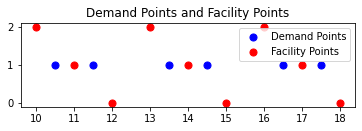

In [28]:
import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots()

# Plot demand points and facility points
dem_b.plot(ax=ax, color='blue', markersize=50, label='Demand Points')
fac_b.plot(ax=ax, color='red', markersize=50, label='Facility Points')

# Set plot title and legend
ax.set_title('Demand Points and Facility Points')
ax.legend()

# Show the plot
plt.show()

In [29]:
initial_k_b = [1] * len(sample_client_b)
prob_b = K_Nearest_PMedian.from_geodataframe(
    initial_k_b, 
    dem_b, 
    fac_b,
    'geometry',
    'geometry',
    'demand',
    facility_capacity_col = 'capacity',
    distance_metric = "euclidean")

In [30]:
for i in range(6):
    for j in range(9):
        if (i, j) in prob_b.cli_assgn_vars and prob_b.cli_assgn_vars[(i, j)].value() == 1:
            print(i, j)

0 1
1 0
2 4
3 3
4 7
5 6
